In [11]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# FAMD
Multiple factor analysis (MFA)  is meant to be used when you have groups of variables. In practice it builds a PCA on each group -- or an MCA, depending on the types of the group's variables. It then constructs a global PCA on the results of the so-called partial PCAs -- or MCAs.

In [12]:
X = pd.read_csv('../data/Customer_churn.csv')

Prepare the data similarly to MCA and PCA but with one non-categorical attribute - MonthlyCharges.

In [13]:
def tenure(data):
    # if the customer stays with the company <= 1 year return 'Short' label
    # otherwise return 'Long'
    if 0 < data  <= 24 :
        return 'Short'
    else:
        return 'Long'

def charges(data):
    # discretize monthly charges variable 
    if 0 < data  <= 70 :
        return 'LowCharge'
    else:
        return 'HighCharge'

X['SeniorCitizen'].replace({0: 'No', 1: 'Yes'}, inplace=True)
X['tenure'] = X['tenure'].apply(tenure)
X.drop(['customerID', 'TotalCharges'], axis=1, inplace=True)

Initialize FAMD object and fit the data.

In [17]:
famd = prince.FAMD(
     n_components=10,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
)
famd = famd.fit(X.drop('Churn', axis='columns'))

In [ ]:
famd.explained_inertia_

array([0.39727442, 0.11218292, 0.08238004, 0.04142112, 0.03622786,
       0.03097726, 0.03046294, 0.02534432, 0.02475228, 0.02429468])

In [16]:
np.cumsum(famd.explained_inertia_)

array([0.39727442, 0.50945686, 0.59183318, 0.63323186, 0.66935161])

Print coordinates of principal components.

In [5]:
famd.row_coordinates(X)


,0,1
0,0.701638,1.546829
1,0.161835,0.421094
2,0.190299,0.886057
3,0.485829,0.770001
4,-0.395479,0.910269
...,...,...
7038,-0.762043,-0.457239
7039,-1.424929,-0.918892
7040,0.762161,1.475748
7041,-0.550172,0.642050


Display FAMD plot coordinates.

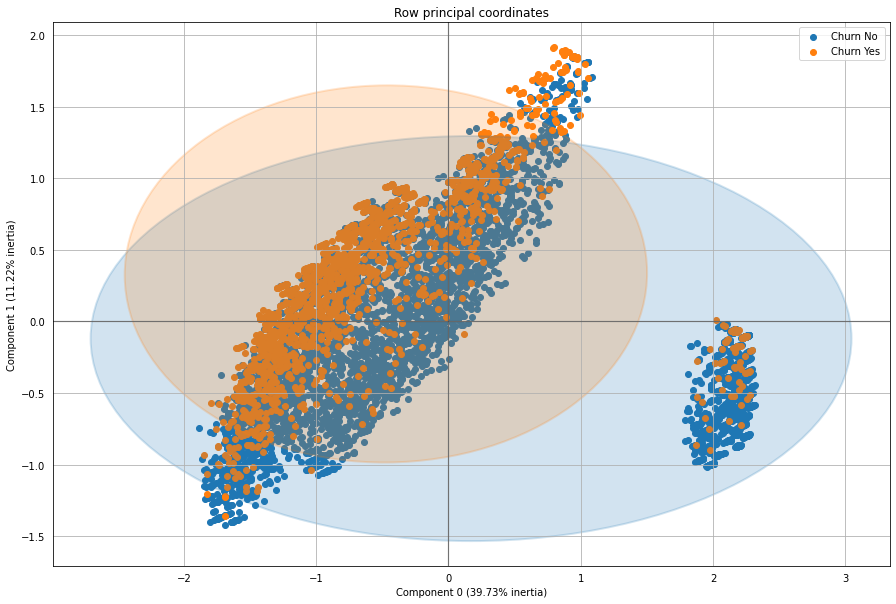

In [6]:
ax = famd.plot_row_coordinates(
     X,
     ax=None,
     figsize=(15, 10),
     x_component=0,
     y_component=1,
     labels=[],
     color_labels=['Churn {}'.format(t) for t in X['Churn']],
     ellipse_outline=True,
     ellipse_fill=True,
     show_points=True
)

Plot shows how dataset elements position relatively to principal components with a color division between customers who have left the company and those who have not. 

Customers who remain have tend to have a higher value of the first component and a lower value of the second component.

Come points are distant from the rest - those are customers without internet service.

### FAMD kNN classification

Split data into train and test sets. Fitting data to kNN classifire model and calculating the accuracy. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(famd.row_coordinates(X), X['Churn'], test_size=0.3, random_state=42)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

target_names = ["Churned", "Didn't churn"]

prediction = neigh.predict(X_test)
print("Test set")
print(classification_report(y_test, prediction, target_names=target_names))

prediction = neigh.predict(X_train)
print("Train set")
print(classification_report(y_train, prediction, target_names=target_names))

Test set
              precision    recall  f1-score   support

     Churned       0.82      0.85      0.83      1539
Didn't churn       0.55      0.50      0.52       574

    accuracy                           0.75      2113
   macro avg       0.69      0.67      0.68      2113
weighted avg       0.75      0.75      0.75      2113

Train set
              precision    recall  f1-score   support

     Churned       0.89      0.93      0.91      3635
Didn't churn       0.76      0.67      0.71      1295

    accuracy                           0.86      4930
   macro avg       0.82      0.80      0.81      4930
weighted avg       0.85      0.86      0.85      4930



### Measure FAMD time complexity

Measure time of FAMD algorithm fitting on truncated data.

In [8]:
data_sizes = np.arange(100, X.shape[0], step=1000)
repetition_count = 5
time_measure = []
for size in data_sizes:
    sum = 0
    for i in range(repetition_count):
        start = time.time()
        famd.fit(X.drop('Churn', axis='columns').iloc[:size, :])
        stop = time.time()
        sum += stop-start
    time_measure.append(sum/repetition_count)

df_time = pd.DataFrame({'size': data_sizes, 'time': time_measure})
df_time.to_csv('../results/FAMD_time_perform.csv', index=False)

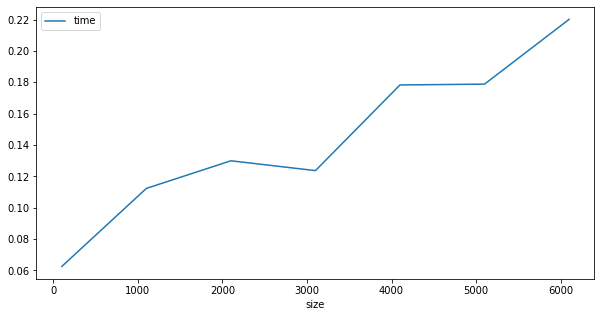

In [9]:
df_time.plot('size', 'time', figsize=(10,5))
plt.show()